# Genetic Algorithm

In [136]:
from CNF_Creator import *
import numpy as np
import random
import time
import matplotlib.pyplot as plt
random.seed(1)

In [137]:
class State:

    fitness=0
    
    def __init__(self, assgn, cnf):
        self.assignment=assgn
        self.fitness = self.__fitness_fun(cnf)
    
    def __fitness_fun(self, cnf):
        return np.sum([(np.sign(i[0])*self.assignment[abs(i[0])]+np.sign(i[1])*self.assignment[abs(i[1])]+np.sign(i[2])*self.assignment[abs(i[2])]) > -3 for i in cnf])/len(cnf)

In [138]:
class GeneticAlgorithm:
    
    population = [] #array of states
    
    
    def __init__(self, pop_size=20):
        self.pop_size=pop_size
        self.best_solution=None
        
    
    def generate_random_state(self, cnf, num_symbols=50):
        assign=np.random.randint(0,2, size= num_symbols+1)
        return State(assgn=np.where(assign>0,1,-1), cnf=cnf)
    
    def combination(self, parent1, parent2, cnf):
        rand_index= random.randint(2, len(parent1.assignment)-1)
        child = State(assgn=np.concatenate((parent1.assignment[0:rand_index+1],parent2.assignment[rand_index+1:len(parent2.assignment)])), cnf=cnf)
        return child
    
    def mutation(self, state, prob=0.01):
        state.assignment*=np.random.choice(np.array([1,-1]), size = len(state.assignment), p=np.array([1-prob,prob]))
    
    def optimize(self,cnf, num_symbols=50, timeoutSeconds=45):
        generations = 0
        
        for i in range(self.pop_size):
            self.population.append(self.generate_random_state(cnf=cnf, num_symbols=num_symbols))
            
        timeout= time.time()+timeoutSeconds
        
        while True:
            for i in self.population:
                if self.best_solution==None or self.best_solution.fitness<i.fitness:
                    self.best_solution = i
            #print (f"Best soln for Generation {generations}: {self.best_solution.fitness}")
            if time.time() > timeout or (max([i.fitness for i in self.population])==1):
                break
                
            sum_fitness=(np.sum([i.fitness for i in self.population])) 
            prob_array=[i.fitness for i in self.population]/sum_fitness
            new_population = []
            for i in range(self.pop_size):
                
                parent1=np.random.choice(a=self.population, p=prob_array)
                parent2=np.random.choice(a=self.population, p=prob_array)
                
                child = self.combination (parent1, parent2, cnf)
                self.mutation(state=child)
                new_population.append(child)
                                
            self.population = new_population
            generations=generations+1
            
        return self.population       

In [175]:
random.seed(1)
best_fitness_vanilla=[]
best_time_vanilla=[]
for i in range(100,301,20):
    currSum=0
    currTime=0
    for j in range (10):
        cnfCreator=CNF_Creator(n=50)
        sentence=cnfCreator.CreateRandomSentence(m=i)
        model=GeneticAlgorithm()
        startTime=time.time()
        population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=45)
        endTime=time.time()
        currSum+=model.best_solution.fitness
        currTime+=endTime-startTime
    best_fitness_vanilla.append(currSum/10)
    best_time_vanilla.append(currTime/10)
    print(f"{i} clauses: {best_fitness_vanilla[-1]} {best_time_vanilla[-1]}")

100 clauses: 0.9949999999999999 32.285588192939755
120 clauses: 0.9833333333333331 45.01688904762268
140 clauses: 0.9778571428571429 45.0189120054245
160 clauses: 0.971875 45.02268824577332
180 clauses: 0.9671111111111111 45.024524903297426
200 clauses: 0.961 45.02932457923889
220 clauses: 0.9618181818181817 45.02958025932312
240 clauses: 0.9600000000000002 45.03031210899353
260 clauses: 0.9600000000000002 45.03307056427002
280 clauses: 0.9600714285714286 45.03444509506225
300 clauses: 0.9600000000000002 45.03967657089233


In [141]:
class ImprovedGeneticAlgorithm: 
    population = [] #array of states
    
    def __init__(self, pop_size=50):
        self.pop_size=pop_size
        self.best_solution=None
        
    def generate_random_state(self, cnf, num_symbols=50):
        assign=np.random.randint(0,2, size= num_symbols+1)
        return State(assgn=np.where(assign>0,1,-1), cnf=cnf)
    
    def combination(self, parent1, parent2, cnf):
        rand_index= random.randint(1, len(parent1.assignment)-1)
        child1 = State(assgn=np.concatenate((parent1.assignment[0:rand_index+1],parent2.assignment[rand_index+1:len(parent2.assignment)])), cnf=cnf)
        child2 = State(assgn=np.concatenate((parent2.assignment[0:rand_index+1],parent1.assignment[rand_index+1:len(parent1.assignment)])), cnf=cnf)
        return child1 if child1.fitness>child2.fitness else child2
        
    
    def mutation(self, state, prob=0.01):
        state.assignment*=np.random.choice(np.array([1,-1]), size = len(state.assignment), p=np.array([1-prob,prob]))
            
    def elitism(self, new_population, elitism_count):
        self.population.sort(key=lambda x: x.fitness, reverse=True)
        new_population.sort(key= lambda x: x.fitness, reverse=True)
        
        self.popluation = self.population[0:elitism_count]+new_population[0:len(new_population)-elitism_count]

    
    def cull(self, culling_count, new_population, prob_array,cnf):
        for i in range(culling_count):
            parent1=np.random.choice(a=self.population, p=prob_array)
            parent2=np.random.choice(a=self.population, p=prob_array)

            child = self.combination (parent1, parent2, cnf)
            self.mutation(state=child)
            new_population.append(child)
            
        new_population.sort(key=lambda x:x.fitness, reverse=True)
        new_population = new_population[0:len(self.population)]
            
                
    
    def optimize(self, cnf, num_symbols= 50, timeoutSeconds=45, elitism = False, culling= False, softmax_activation= False, culling_count=5, elitism_count=5):
        generations = 0
        
        for i in range(self.pop_size):
            self.population.append(self.generate_random_state(cnf=cnf, num_symbols=num_symbols))
            
        timeout= time.time()+timeoutSeconds
        
        while True:
            for i in self.population:
                if self.best_solution==None or self.best_solution.fitness<i.fitness:
                    self.best_solution = i
            #print (f"Best soln for Generation {generations}: {self.best_solution.fitness}")
            if time.time() > timeout or (max([i.fitness for i in self.population])==1):
                break
                
            if softmax_activation:
                sum_probs=np.sum([np.exp(i.fitness) for i in self.population if i.fitness!=0])
                prob_array=[np.exp(i.fitness)/sum_probs if i.fitness!=0 else 0 for i in self.population]             
            else:
                sum_fitness=(np.sum([i.fitness for i in self.population])) 
                prob_array=[i.fitness for i in self.population]/sum_fitness
                
            new_population = []
            for i in range(self.pop_size):
                
                parent1=np.random.choice(a=self.population, p=prob_array)
                parent2=np.random.choice(a=self.population, p=prob_array)
                
                child = self.combination (parent1, parent2, cnf)
                self.mutation(state=child)
                new_population.append(child)
                
            if culling:
                self.cull(culling_count, new_population, prob_array,cnf)
            
            if elitism:
                self.elitism(new_population, elitism_count)
            else:
                self.population = new_population
            
                
            generations=generations+1
            
        return self.population       

In [171]:
random.seed(1)
best_fitness=[]
best_time=[]
for i in range(100,301,20):
    currSum=0
    currTime=0
    for j in range (10):
        cnfCreator=CNF_Creator(n=50)
        sentence=cnfCreator.CreateRandomSentence(m=i)
        model=ImprovedGeneticAlgorithm(pop_size=50)
        startTime=time.time()
        population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=45)
        endTime=time.time()
        currTime+=endTime-startTime
        currSum+=model.best_solution.fitness
    best_fitness.append(currSum/10)
    best_time.append(currTime/10)
    print(f"{i} clauses: {best_fitness[-1]}, {best_time[-1]}s")

100 clauses: 1.0, 6.47000560760498s
120 clauses: 1.0, 6.397776484489441s
140 clauses: 1.0, 7.186888098716736s
160 clauses: 0.99875, 22.23996865749359s
180 clauses: 0.9977777777777778, 26.968999433517457s
200 clauses: 0.9934999999999998, 45.118117690086365s
220 clauses: 0.9895454545454546, 45.1123991727829s
240 clauses: 0.9904166666666667, 45.139688372612s
260 clauses: 0.9868461538461538, 45.15694868564606s
280 clauses: 0.9832857142857142, 45.18344619274139s
300 clauses: 0.9836666666666666, 45.20692548751831s


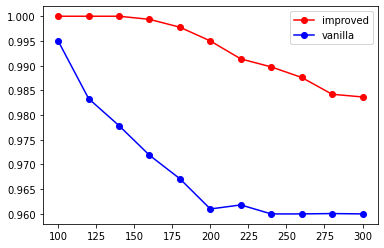

In [176]:
plt.plot(range(100,301,20), best_fitness, color="red", label="Improved", marker="o")
plt.plot(range(100,301,20), best_fitness_vanilla, color="blue", label="Vanilla", marker="o")
plt.legend()

In [173]:
random.seed(1)
best_fitness=[]
best_time=[]
for i in range(100,301,20):
    currSum=0
    currTime=0
    for j in range (10):
        cnfCreator=CNF_Creator(n=50)
        sentence=cnfCreator.CreateRandomSentence(m=i)
        model=ImprovedGeneticAlgorithm(pop_size=100)
        startTime=time.time()
        population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=45)
        endTime=time.time()
        currTime+=endTime-startTime
        currSum+=model.best_solution.fitness
    best_fitness.append(currSum/10)
    best_time.append(currTime/10)
    print(f"{i} clauses: {best_fitness[-1]}, {best_time[-1]}s")

100 clauses: 1.0, 12.415067267417907s
120 clauses: 1.0, 14.146907472610474s
140 clauses: 1.0, 14.412429094314575s
160 clauses: 0.999375, 18.962187695503236s
180 clauses: 0.9977777777777778, 28.785188126564027s
200 clauses: 0.9949999999999999, 40.86514050960541s
220 clauses: 0.9913636363636362, 45.23381931781769s
240 clauses: 0.9897500000000001, 45.321691846847536s
260 clauses: 0.9876153846153848, 45.29329874515533s
280 clauses: 0.9842142857142857, 45.30075390338898s
300 clauses: 0.9836666666666668, 45.301367378234865s


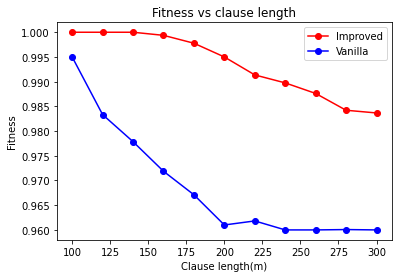

In [194]:
plt.title("Fitness vs clause length")
plt.xlabel("Clause length(m)")
plt.ylabel("Fitness")
plt.plot(range(100,301,20), best_fitness, color="red", label="Improved", marker="o")
plt.plot(range(100,301,20), best_fitness_vanilla, color="blue", label="Vanilla", marker="o")
plt.legend()

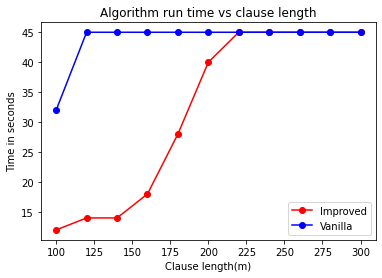

In [195]:
plt.title("Algorithm run time vs clause length")
plt.xlabel("Clause length(m)")
plt.ylabel("Time in seconds")
plt.plot(range(100,301,20),[int(x) for x in best_time], color="red", label="Improved", marker="o")
plt.plot(range(100,301,20), [int(x) for x in best_time_vanilla], color="blue", label="Vanilla", marker="o")
plt.legend()


In [188]:
random.seed(1)
best_fitness_impr=[]
best_time_impr=[]
for i in range(100,301,20):
    currSum=0
    currTime=0
    for j in range (10):
        cnfCreator=CNF_Creator(n=50)
        sentence=cnfCreator.CreateRandomSentence(m=i)
        model=ImprovedGeneticAlgorithm(pop_size=10)
        startTime=time.time()
        population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=45)
        endTime=time.time()
        currTime+=endTime-startTime
        currSum+=model.best_solution.fitness
    best_fitness_impr.append(currSum/10)
    best_time_impr.append(currTime/10)
    print(f"{i} clauses: {best_fitness_impr[-1]}, {best_time_impr[-1]}s")

100 clauses: 1.0, 2.106548619270325s
120 clauses: 1.0, 3.515884804725647s
140 clauses: 1.0, 7.220806312561035s
160 clauses: 0.999375, 7.801376843452454s
180 clauses: 0.9988888888888889, 18.91837682723999s
200 clauses: 0.9955, 36.858193612098695s
220 clauses: 0.9954545454545455, 35.25337371826172s
240 clauses: 0.9883333333333335, 45.0193231344223s
260 clauses: 0.9892307692307692, 45.021118664741515s
280 clauses: 0.9872857142857143, 45.02233934402466s
300 clauses: 0.9823333333333336, 45.02363510131836s


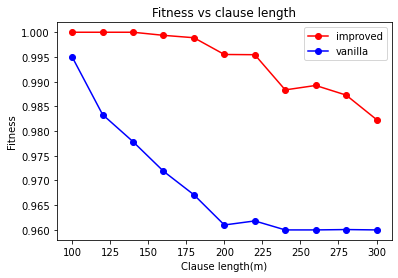

In [196]:
plt.title("Fitness vs clause length")
plt.xlabel("Clause length(m)")
plt.ylabel("Fitness")
plt.plot(range(100,301,20), best_fitness_impr, color="red", label="improved", marker="o")
plt.plot(range(100,301,20), best_fitness_vanilla, color="blue", label="vanilla", marker="o")
plt.legend()

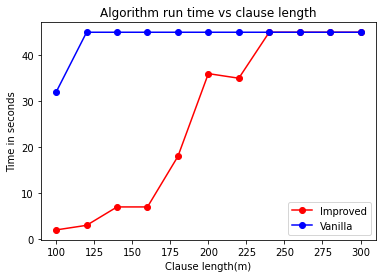

In [197]:
plt.title("Algorithm run time vs clause length")
plt.xlabel("Clause length(m)")
plt.ylabel("Time in seconds")
plt.plot(range(100,301,20),[int(x) for x in best_time_impr], color="red", label="Improved", marker="o")
plt.plot(range(100,301,20), [int(x) for x in best_time_vanilla], color="blue", label="Vanilla", marker="o")
plt.legend()


In [198]:
random.seed(1)
cnfCreator=CNF_Creator(n=50)
sentence=cnfCreator.ReadCNFfromCSVfile()
model=GeneticAlgorithm()
startTime=time.time()
population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=45)
endTime=time.time()
print (f"Vanilla Found best fitness:{model.best_solution.fitness} in {endTime-startTime}s")
model=ImprovedGeneticAlgorithm(pop_size=10)
startTime=time.time()
population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=45)
endTime=time.time()
print (f"Improved Found best fitness:{model.best_solution.fitness} in {endTime-startTime}s")

Vanilla Found best fitness:0.98 in 45.01899576187134s
Improved Found best fitness:1.0 in 1.689037561416626s


In [214]:
random.seed(1)
np.random.seed(1)

cnfCreator=CNF_Creator(n=50)
sentence=cnfCreator.ReadCNFfromCSVfile()
model=ImprovedGeneticAlgorithm(pop_size=10)
startTime=time.time()
population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=45)
endTime=time.time()
print (f"Improved Found best fitness:{model.best_solution.fitness} in {endTime-startTime}s")

Improved Found best fitness:1.0 in 2.1710381507873535s


In [219]:
cnfCreator=CNF_Creator(n=50)
sentence=cnfCreator.ReadCNFfromCSVfile(file_name='CNF2.csv')
model=ImprovedGeneticAlgorithm(pop_size=10)
startTime=time.time()
population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=45)
endTime=time.time()
print (f"Improved Found best fitness:{model.best_solution.fitness} in {endTime-startTime}s")

Improved Found best fitness:1.0 in 20.50123381614685s


In [220]:
cnfCreator=CNF_Creator(n=50)
sentence=cnfCreator.ReadCNFfromCSVfile(file_name='CNF3.csv')
model=ImprovedGeneticAlgorithm(pop_size=10)
startTime=time.time()
population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=45)
endTime=time.time()
print (f"Improved Found best fitness:{model.best_solution.fitness} in {endTime-startTime}s")

Improved Found best fitness:0.996 in 45.03364872932434s


In [221]:
cnfCreator=CNF_Creator(n=50)
sentence=cnfCreator.ReadCNFfromCSVfile(file_name='CNF4.csv')
model=ImprovedGeneticAlgorithm(pop_size=10)
startTime=time.time()
population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=45)
endTime=time.time()
print (f"Improved Found best fitness:{model.best_solution.fitness} in {endTime-startTime}s")

Improved Found best fitness:0.98 in 45.049294233322144s


In [222]:
cnfCreator=CNF_Creator(n=50)
sentence=cnfCreator.ReadCNFfromCSVfile(file_name='CNF5.csv')
model=ImprovedGeneticAlgorithm(pop_size=10)
startTime=time.time()
population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=45)
endTime=time.time()
print (f"Improved Found best fitness:{model.best_solution.fitness} in {endTime-startTime}s")

Improved Found best fitness:0.9828571428571429 in 45.05257177352905s


# Genetic Algorithm and associated tests

In [131]:
class State:
    
    assignment = []
    fitness=0
    
    def __init__(self, assgn, cnf):
        self.assignment=assgn
        self.fitness = self.__fitness_fun(cnf)
    
    def __fitness_fun(self, cnf):
        return np.sum([(np.sign(i[0])*self.assignment[abs(i[0])]+np.sign(i[1])*self.assignment[abs(i[1])]+np.sign(i[2])*self.assignment[abs(i[2])]) > -3 for i in cnf])/len(cnf)

In [48]:
class GeneticAlgorithm:
    
    population = [] #array of states
    
    
    def __init__(self, pop_size=20):
        self.pop_size=pop_size
        self.best_solution=None
        
    
    def generate_random_state(self, cnf, num_symbols=50):
        return State(assgn= [ -1 if i == False else 1 for i in (np.random.randint(-5, 5, num_symbols+1) < 0) ], cnf=cnf)
    
    def combination(self, parent1, parent2, cnf):
        rand_index= random.randint(1, len(parent1.assignment)-1)
        new_assgn=parent1.assignment[0:rand_index+1]
        new_assgn.extend(parent2.assignment[rand_index+1:len(parent2.assignment)])
        child = State(assgn=new_assgn, cnf=cnf)
        return child
    
    def mutation(self, state, prob=0.01):
        for i in range (len(state.assignment)):
            if np.random.uniform() <= prob:
                state.assignment[i]=state.assignment[i]*-1
    
    def optimize(self,cnf, num_symbols=50, timeoutSeconds=45):
        generations = 0
        
        for i in range(self.pop_size):
            self.population.append(self.generate_random_state(cnf=cnf, num_symbols=num_symbols))
            
        timeout= time.time()+timeoutSeconds
        
        while True:
            for i in self.population:
                if self.best_solution==None or self.best_solution.fitness<i.fitness:
                    self.best_solution = i
            print (f"Best soln for Generation {generations}: {self.best_solution.fitness}")
            if time.time() > timeout or (max([i.fitness for i in self.population])==1):
                break
                
            sum_fitness=(np.sum([i.fitness for i in self.population])) 
            prob_array=[i.fitness for i in self.population]/sum_fitness
            new_population = []
            for i in range(self.pop_size):
                
                parent1=np.random.choice(a=self.population, p=prob_array)
                parent2=np.random.choice(a=self.population, p=prob_array)
                
                child = self.combination (parent1, parent2, cnf)
                self.mutation(state=child)
                new_population.append(child)
                                
            self.population = new_population
            generations=generations+1
            
        return self.population       

In [115]:
class ImprovedGeneticAlgorithm: 
    population = [] #array of states
    
    def __init__(self, pop_size=50):
        self.pop_size=pop_size
        self.best_solution=None
        
    def generate_random_state(self, cnf, num_symbols=50):
        return State(assgn= [ -1 if i == False else 1 for i in (np.random.randint(-5, 5, num_symbols+1) < 0) ], cnf=cnf)
        
    def combination(self, parent1, parent2,cnf):
        rand_index= random.randint(1, len(parent1.assignment)-1)
        new_assgn1=parent1.assignment[0:rand_index+1]
        new_assgn1.extend(parent2.assignment[rand_index+1:len(parent2.assignment)])
        child1 = State(assgn=new_assgn1, cnf=cnf)
        
        new_assgn2=parent2.assignment[0:rand_index+1]
        new_assgn2.extend(parent1.assignment[rand_index+1:len(parent1.assignment)])
        child2= State(assgn= new_assgn2, cnf=cnf)
        #return child1
        return child1 if child1.fitness>child2.fitness else child2
    
    def mutation(self, state, prob=0.01):
        rand_index=random.randint(1, len(state.assignment)-1)
        if np.random.uniform() <= prob:
            state.assignment[rand_index]=state.assignment[rand_index]*-1
            
    def elitism(self, new_population):
        total_population=self.population+new_population
        total_population.sort(key= lambda x: x.fitness, reverse = True)
        self.population = total_population[0:min(self.pop_size, len(total_population))]
    
    def cull(self, threshold=0.0199):
        prob_array=[i.fitness for i in self.population]/(np.sum([i.fitness for i in self.population])) 
        #print (prob_array)
        for i in range(len(prob_array)): 
            if prob_array[i] < threshold:
                self.population[i].fitness=0
                
    
    def optimize(self, cnf, num_symbols= 50, timeoutSeconds=45, elitism = False, culling= False, softmax_activation= False, culling_threshold=0.0198):
        generations = 0
        
        for i in range(self.pop_size):
            self.population.append(self.generate_random_state(cnf=cnf, num_symbols=num_symbols))
            
        timeout= time.time()+timeoutSeconds
        
        while True:
            for i in self.population:
                if self.best_solution==None or self.best_solution.fitness<i.fitness:
                    self.best_solution = i
            #print (f"Best soln for Generation {generations}: {self.best_solution.fitness}")
            if time.time() > timeout or (max([i.fitness for i in self.population])==1):
                break
                
            if softmax_activation:
                sum_probs=np.sum([np.exp(i.fitness) for i in self.population if i.fitness!=0])
                prob_array=[np.exp(i.fitness)/sum_probs if i.fitness!=0 else 0 for i in self.population]             
            else:
                sum_fitness=(np.sum([i.fitness for i in self.population])) 
                prob_array=[i.fitness for i in self.population]/sum_fitness
                
            new_population = []
            for i in range(self.pop_size):
                
                parent1=np.random.choice(a=self.population, p=prob_array)
                parent2=np.random.choice(a=self.population, p=prob_array)
                
                child = self.combination (parent1, parent2, cnf)
                self.mutation(state=child)
                new_population.append(child)
            
            if elitism:
                self.elitism(new_population)
            else:
                self.population = new_population
            
            
            if culling:
                self.cull(threshold=culling_threshold)
                
            generations=generations+1
            
        return self.population       

# New improved

In [120]:
class ImprovedGeneticAlgorithm: 
    population = [] #array of states
    
    def __init__(self, pop_size=50):
        self.pop_size=pop_size
        self.best_solution=None
        
    def generate_random_state(self, cnf, num_symbols=50):
        return State(assgn= [ -1 if i == False else 1 for i in (np.random.randint(-5, 5, num_symbols+1) < 0) ], cnf=cnf)
        
    def combination(self, parent1, parent2,cnf):
        rand_index= random.randint(1, len(parent1.assignment)-1)
        new_assgn1=parent1.assignment[0:rand_index+1]
        new_assgn1.extend(parent2.assignment[rand_index+1:len(parent2.assignment)])
        child1 = State(assgn=new_assgn1, cnf=cnf)
        
        new_assgn2=parent2.assignment[0:rand_index+1]
        new_assgn2.extend(parent1.assignment[rand_index+1:len(parent1.assignment)])
        child2= State(assgn= new_assgn2, cnf=cnf)
        #return child1
        return child1 if child1.fitness>child2.fitness else child2
    
    def mutation(self, state, prob=0.01):
        for i in range(len(state.assignment)):
            if np.random.uniform() <= prob:
                state.assignment[i]=state.assignment[i]*-1
            
    def elitism(self, new_population, elitism_count):
        self.population.sort(key=lambda x: x.fitness, reverse=True)
        new_population.sort(key= lambda x: x.fitness, reverse=True)
        
        self.popluation = self.population[0:elitism_count]+new_population[0:len(new_population)-elitism_count]

    
    def cull(self, culling_count, new_population, prob_array,cnf):
        for i in range(culling_count):
            parent1=np.random.choice(a=self.population, p=prob_array)
            parent2=np.random.choice(a=self.population, p=prob_array)

            child = self.combination (parent1, parent2, cnf)
            self.mutation(state=child)
            new_population.append(child)
            
        new_population.sort(key=lambda x:x.fitness, reverse=True)
        new_population = new_population[0:len(self.population)]
            
                
    
    def optimize(self, cnf, num_symbols= 50, timeoutSeconds=45, elitism = False, culling= False, softmax_activation= False, culling_count=5, elitism_count=5):
        generations = 0
        
        for i in range(self.pop_size):
            self.population.append(self.generate_random_state(cnf=cnf, num_symbols=num_symbols))
            
        timeout= time.time()+timeoutSeconds
        
        while True:
            for i in self.population:
                if self.best_solution==None or self.best_solution.fitness<i.fitness:
                    self.best_solution = i
            #print (f"Best soln for Generation {generations}: {self.best_solution.fitness}")
            if time.time() > timeout or (max([i.fitness for i in self.population])==1):
                break
                
            if softmax_activation:
                sum_probs=np.sum([np.exp(i.fitness) for i in self.population if i.fitness!=0])
                prob_array=[np.exp(i.fitness)/sum_probs if i.fitness!=0 else 0 for i in self.population]             
            else:
                sum_fitness=(np.sum([i.fitness for i in self.population])) 
                prob_array=[i.fitness for i in self.population]/sum_fitness
                
            new_population = []
            for i in range(self.pop_size):
                
                parent1=np.random.choice(a=self.population, p=prob_array)
                parent2=np.random.choice(a=self.population, p=prob_array)
                
                child = self.combination (parent1, parent2, cnf)
                self.mutation(state=child)
                new_population.append(child)
                
            if culling:
                self.cull(culling_count, new_population, prob_array,cnf)
            
            if elitism:
                self.elitism(new_population, elitism_count)
            else:
                self.population = new_population
            
                
            generations=generations+1
            
        return self.population       

In [121]:
cnfCreator=CNF_Creator(n=50)
sentence=cnfCreator.ReadCNFfromCSVfile()

In [39]:
model=GeneticAlgorithm()
population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=45)

Best soln for Generation 0: 0.93
Best soln for Generation 1: 0.93
Best soln for Generation 2: 0.93
Best soln for Generation 3: 0.93
Best soln for Generation 4: 0.93
Best soln for Generation 5: 0.93
Best soln for Generation 6: 0.93
Best soln for Generation 7: 0.94
Best soln for Generation 8: 0.94
Best soln for Generation 9: 0.94
Best soln for Generation 10: 0.94
Best soln for Generation 11: 0.97
Best soln for Generation 12: 0.97
Best soln for Generation 13: 0.97
Best soln for Generation 14: 0.97
Best soln for Generation 15: 0.97
Best soln for Generation 16: 0.97
Best soln for Generation 17: 0.97
Best soln for Generation 18: 0.97
Best soln for Generation 19: 0.97
Best soln for Generation 20: 0.97
Best soln for Generation 21: 0.97
Best soln for Generation 22: 0.97
Best soln for Generation 23: 0.97
Best soln for Generation 24: 0.97
Best soln for Generation 25: 0.97
Best soln for Generation 26: 0.97
Best soln for Generation 27: 0.97
Best soln for Generation 28: 0.97
Best soln for Generation

Best soln for Generation 246: 0.99
Best soln for Generation 247: 0.99
Best soln for Generation 248: 0.99
Best soln for Generation 249: 0.99
Best soln for Generation 250: 0.99
Best soln for Generation 251: 0.99
Best soln for Generation 252: 0.99
Best soln for Generation 253: 0.99
Best soln for Generation 254: 0.99
Best soln for Generation 255: 0.99
Best soln for Generation 256: 0.99
Best soln for Generation 257: 0.99
Best soln for Generation 258: 0.99
Best soln for Generation 259: 0.99
Best soln for Generation 260: 0.99
Best soln for Generation 261: 0.99
Best soln for Generation 262: 0.99
Best soln for Generation 263: 0.99
Best soln for Generation 264: 0.99
Best soln for Generation 265: 0.99
Best soln for Generation 266: 0.99
Best soln for Generation 267: 0.99
Best soln for Generation 268: 0.99
Best soln for Generation 269: 0.99
Best soln for Generation 270: 0.99
Best soln for Generation 271: 0.99
Best soln for Generation 272: 0.99
Best soln for Generation 273: 0.99
Best soln for Genera

Best soln for Generation 481: 0.99
Best soln for Generation 482: 0.99
Best soln for Generation 483: 0.99
Best soln for Generation 484: 0.99
Best soln for Generation 485: 0.99
Best soln for Generation 486: 0.99
Best soln for Generation 487: 0.99
Best soln for Generation 488: 0.99
Best soln for Generation 489: 0.99
Best soln for Generation 490: 0.99
Best soln for Generation 491: 0.99
Best soln for Generation 492: 0.99
Best soln for Generation 493: 0.99
Best soln for Generation 494: 0.99
Best soln for Generation 495: 0.99
Best soln for Generation 496: 0.99
Best soln for Generation 497: 0.99
Best soln for Generation 498: 0.99
Best soln for Generation 499: 0.99
Best soln for Generation 500: 0.99
Best soln for Generation 501: 0.99
Best soln for Generation 502: 0.99
Best soln for Generation 503: 0.99
Best soln for Generation 504: 0.99
Best soln for Generation 505: 0.99
Best soln for Generation 506: 0.99
Best soln for Generation 507: 0.99
Best soln for Generation 508: 0.99
Best soln for Genera

Best soln for Generation 716: 0.99
Best soln for Generation 717: 0.99
Best soln for Generation 718: 0.99
Best soln for Generation 719: 0.99
Best soln for Generation 720: 0.99
Best soln for Generation 721: 0.99
Best soln for Generation 722: 0.99
Best soln for Generation 723: 0.99
Best soln for Generation 724: 0.99
Best soln for Generation 725: 0.99
Best soln for Generation 726: 0.99
Best soln for Generation 727: 0.99
Best soln for Generation 728: 0.99
Best soln for Generation 729: 0.99
Best soln for Generation 730: 0.99
Best soln for Generation 731: 0.99
Best soln for Generation 732: 0.99
Best soln for Generation 733: 0.99
Best soln for Generation 734: 0.99
Best soln for Generation 735: 0.99
Best soln for Generation 736: 0.99
Best soln for Generation 737: 0.99
Best soln for Generation 738: 0.99
Best soln for Generation 739: 0.99
Best soln for Generation 740: 0.99
Best soln for Generation 741: 0.99
Best soln for Generation 742: 0.99
Best soln for Generation 743: 0.99
Best soln for Genera

Best soln for Generation 957: 0.99
Best soln for Generation 958: 0.99
Best soln for Generation 959: 0.99
Best soln for Generation 960: 0.99
Best soln for Generation 961: 0.99
Best soln for Generation 962: 0.99
Best soln for Generation 963: 0.99
Best soln for Generation 964: 0.99
Best soln for Generation 965: 0.99
Best soln for Generation 966: 0.99
Best soln for Generation 967: 0.99
Best soln for Generation 968: 0.99
Best soln for Generation 969: 0.99
Best soln for Generation 970: 0.99
Best soln for Generation 971: 0.99
Best soln for Generation 972: 0.99
Best soln for Generation 973: 0.99
Best soln for Generation 974: 0.99
Best soln for Generation 975: 0.99
Best soln for Generation 976: 0.99
Best soln for Generation 977: 0.99
Best soln for Generation 978: 0.99
Best soln for Generation 979: 0.99
Best soln for Generation 980: 0.99
Best soln for Generation 981: 0.99
Best soln for Generation 982: 0.99
Best soln for Generation 983: 0.99
Best soln for Generation 984: 0.99
Best soln for Genera

Best soln for Generation 1192: 0.99
Best soln for Generation 1193: 0.99
Best soln for Generation 1194: 0.99
Best soln for Generation 1195: 0.99
Best soln for Generation 1196: 0.99
Best soln for Generation 1197: 0.99
Best soln for Generation 1198: 0.99
Best soln for Generation 1199: 0.99
Best soln for Generation 1200: 0.99
Best soln for Generation 1201: 0.99
Best soln for Generation 1202: 0.99
Best soln for Generation 1203: 0.99
Best soln for Generation 1204: 0.99
Best soln for Generation 1205: 0.99
Best soln for Generation 1206: 0.99
Best soln for Generation 1207: 0.99
Best soln for Generation 1208: 0.99
Best soln for Generation 1209: 0.99
Best soln for Generation 1210: 0.99
Best soln for Generation 1211: 0.99
Best soln for Generation 1212: 0.99
Best soln for Generation 1213: 0.99
Best soln for Generation 1214: 0.99
Best soln for Generation 1215: 0.99
Best soln for Generation 1216: 0.99
Best soln for Generation 1217: 0.99
Best soln for Generation 1218: 0.99
Best soln for Generation 121

Best soln for Generation 1429: 0.99
Best soln for Generation 1430: 0.99
Best soln for Generation 1431: 0.99
Best soln for Generation 1432: 0.99
Best soln for Generation 1433: 0.99
Best soln for Generation 1434: 0.99
Best soln for Generation 1435: 0.99
Best soln for Generation 1436: 0.99
Best soln for Generation 1437: 0.99
Best soln for Generation 1438: 0.99
Best soln for Generation 1439: 0.99
Best soln for Generation 1440: 0.99
Best soln for Generation 1441: 0.99
Best soln for Generation 1442: 0.99
Best soln for Generation 1443: 0.99
Best soln for Generation 1444: 0.99
Best soln for Generation 1445: 0.99
Best soln for Generation 1446: 0.99
Best soln for Generation 1447: 0.99
Best soln for Generation 1448: 0.99
Best soln for Generation 1449: 0.99
Best soln for Generation 1450: 0.99
Best soln for Generation 1451: 0.99
Best soln for Generation 1452: 0.99
Best soln for Generation 1453: 0.99
Best soln for Generation 1454: 0.99
Best soln for Generation 1455: 0.99
Best soln for Generation 145

Best soln for Generation 1668: 0.99
Best soln for Generation 1669: 0.99
Best soln for Generation 1670: 0.99
Best soln for Generation 1671: 0.99
Best soln for Generation 1672: 0.99
Best soln for Generation 1673: 0.99
Best soln for Generation 1674: 0.99
Best soln for Generation 1675: 0.99
Best soln for Generation 1676: 0.99
Best soln for Generation 1677: 0.99
Best soln for Generation 1678: 0.99
Best soln for Generation 1679: 0.99
Best soln for Generation 1680: 0.99
Best soln for Generation 1681: 0.99
Best soln for Generation 1682: 0.99
Best soln for Generation 1683: 0.99
Best soln for Generation 1684: 0.99
Best soln for Generation 1685: 0.99
Best soln for Generation 1686: 0.99
Best soln for Generation 1687: 0.99
Best soln for Generation 1688: 0.99
Best soln for Generation 1689: 0.99
Best soln for Generation 1690: 0.99
Best soln for Generation 1691: 0.99
Best soln for Generation 1692: 0.99
Best soln for Generation 1693: 0.99
Best soln for Generation 1694: 0.99
Best soln for Generation 169

Best soln for Generation 1901: 0.99
Best soln for Generation 1902: 0.99
Best soln for Generation 1903: 0.99
Best soln for Generation 1904: 0.99
Best soln for Generation 1905: 0.99
Best soln for Generation 1906: 0.99
Best soln for Generation 1907: 0.99
Best soln for Generation 1908: 0.99
Best soln for Generation 1909: 0.99
Best soln for Generation 1910: 0.99
Best soln for Generation 1911: 0.99
Best soln for Generation 1912: 0.99
Best soln for Generation 1913: 0.99
Best soln for Generation 1914: 0.99
Best soln for Generation 1915: 0.99
Best soln for Generation 1916: 0.99
Best soln for Generation 1917: 0.99
Best soln for Generation 1918: 0.99
Best soln for Generation 1919: 0.99
Best soln for Generation 1920: 0.99
Best soln for Generation 1921: 0.99
Best soln for Generation 1922: 0.99
Best soln for Generation 1923: 0.99
Best soln for Generation 1924: 0.99
Best soln for Generation 1925: 0.99
Best soln for Generation 1926: 0.99
Best soln for Generation 1927: 0.99
Best soln for Generation 192

Best soln for Generation 2137: 0.99
Best soln for Generation 2138: 0.99
Best soln for Generation 2139: 0.99
Best soln for Generation 2140: 0.99
Best soln for Generation 2141: 0.99
Best soln for Generation 2142: 0.99
Best soln for Generation 2143: 0.99
Best soln for Generation 2144: 0.99
Best soln for Generation 2145: 0.99
Best soln for Generation 2146: 0.99
Best soln for Generation 2147: 0.99
Best soln for Generation 2148: 0.99
Best soln for Generation 2149: 0.99
Best soln for Generation 2150: 0.99
Best soln for Generation 2151: 0.99
Best soln for Generation 2152: 0.99
Best soln for Generation 2153: 0.99
Best soln for Generation 2154: 0.99
Best soln for Generation 2155: 0.99
Best soln for Generation 2156: 0.99
Best soln for Generation 2157: 0.99
Best soln for Generation 2158: 0.99
Best soln for Generation 2159: 0.99
Best soln for Generation 2160: 0.99
Best soln for Generation 2161: 0.99
Best soln for Generation 2162: 0.99
Best soln for Generation 2163: 0.99
Best soln for Generation 216

Best soln for Generation 2374: 0.99
Best soln for Generation 2375: 0.99
Best soln for Generation 2376: 0.99
Best soln for Generation 2377: 0.99
Best soln for Generation 2378: 0.99
Best soln for Generation 2379: 0.99
Best soln for Generation 2380: 0.99
Best soln for Generation 2381: 0.99
Best soln for Generation 2382: 0.99
Best soln for Generation 2383: 0.99
Best soln for Generation 2384: 0.99
Best soln for Generation 2385: 0.99
Best soln for Generation 2386: 0.99
Best soln for Generation 2387: 0.99
Best soln for Generation 2388: 0.99
Best soln for Generation 2389: 0.99
Best soln for Generation 2390: 0.99
Best soln for Generation 2391: 0.99
Best soln for Generation 2392: 0.99
Best soln for Generation 2393: 0.99
Best soln for Generation 2394: 0.99
Best soln for Generation 2395: 0.99
Best soln for Generation 2396: 0.99
Best soln for Generation 2397: 0.99
Best soln for Generation 2398: 0.99
Best soln for Generation 2399: 0.99
Best soln for Generation 2400: 0.99
Best soln for Generation 240

In [257]:
model=ImprovedGeneticAlgorithm(pop_size=50)
population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=45, culling=True)

In [163]:
print(max([i.fitness for i in population]))

1.0


In [150]:
print(model.best_solution.fitness)

1.0


Best improvement

In [178]:
random.seed(1)
best_fitness=[]
for i in range(100,300,20):
    currSum=0
    for j in range (10):
        cnfCreator=CNF_Creator(n=50)
        sentence=cnfCreator.CreateRandomSentence(m=i)
        model=ImprovedGeneticAlgorithm(pop_size=100)
        population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=20)
        currSum+=model.best_solution.fitness
    best_fitness.append(currSum/10)
    print(f"{i} clauses: {best_fitness[-1]}")

100 clauses: 1.0
120 clauses: 1.0
140 clauses: 0.9985714285714286
160 clauses: 0.99875
180 clauses: 0.993888888888889
200 clauses: 0.9934999999999998
220 clauses: 0.9872727272727273
240 clauses: 0.9860833333333334
260 clauses: 0.9860769230769231
280 clauses: 0.9830714285714286


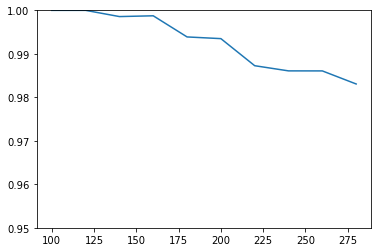

In [181]:
plt.ylim(bottom=0.95)
plt.plot(range(100,300,20), best_fitness)

In [77]:
random.seed(1)
best_fitness=[]
for i in range(100,300,20):
    currSum=0
    for j in range (10):
        cnfCreator=CNF_Creator(n=50)
        sentence=cnfCreator.CreateRandomSentence(m=i)
        model=ImprovedGeneticAlgorithm(pop_size=100)
        population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=20, culling=True, culling_threshold=0.00325)
        currSum+=model.best_solution.fitness
    best_fitness.append(currSum/10)
    print(f"{i} clauses: {best_fitness[-1]}")

100 clauses: 1.0
120 clauses: 0.9975000000000002
140 clauses: 0.9978571428571428
160 clauses: 0.996875
180 clauses: 0.9933333333333334
200 clauses: 0.9884999999999999
220 clauses: 0.985909090909091
240 clauses: 0.9833333333333332
260 clauses: 0.9762307692307692
280 clauses: 0.9767142857142856


In [122]:
#new random
random.seed(1)
best_fitness=[]
for i in range(100,300,20):
    currSum=0
    for j in range (10):
        cnfCreator=CNF_Creator(n=50)
        sentence=cnfCreator.CreateRandomSentence(m=i)
        model=ImprovedGeneticAlgorithm(pop_size=100)
        population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=20)
        currSum+=model.best_solution.fitness
    best_fitness.append(currSum/10)
    print(f"{i} clauses: {best_fitness[-1]}")

100 clauses: 1.0
120 clauses: 1.0
140 clauses: 1.0
160 clauses: 0.99875
180 clauses: 0.9972222222222221
200 clauses: 0.994
220 clauses: 0.9913636363636364
240 clauses: 0.9887499999999999
260 clauses: 0.9834615384615386
280 clauses: 0.9810714285714284


In [123]:
#new random with 10 pop size
random.seed(1)
best_fitness=[]
for i in range(100,300,20):
    currSum=0
    for j in range (10):
        cnfCreator=CNF_Creator(n=50)
        sentence=cnfCreator.CreateRandomSentence(m=i)
        model=ImprovedGeneticAlgorithm(pop_size=10)
        population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=20)
        currSum+=model.best_solution.fitness
    best_fitness.append(currSum/10)
    print(f"{i} clauses: {best_fitness[-1]}")

100 clauses: 1.0
120 clauses: 1.0
140 clauses: 1.0
160 clauses: 0.9981250000000002
180 clauses: 0.9961111111111111
200 clauses: 0.9945000000000002
220 clauses: 0.9931818181818182
240 clauses: 0.9870833333333335
260 clauses: 0.9842307692307692
280 clauses: 0.9824999999999999


In [112]:
#old random
random.seed(1)
best_fitness=[]
for i in range(100,300,20):
    currSum=0
    for j in range (10):
        cnfCreator=CNF_Creator(n=50)
        sentence=cnfCreator.CreateRandomSentence(m=i)
        model=ImprovedGeneticAlgorithm(pop_size=100)
        population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=20)
        currSum+=model.best_solution.fitness
    best_fitness.append(currSum/10)
    print(f"{i} clauses: {best_fitness[-1]}")

100 clauses: 1.0
120 clauses: 1.0
140 clauses: 0.9971428571428571
160 clauses: 0.9925
180 clauses: 0.9927777777777778
200 clauses: 0.9880000000000001
220 clauses: 0.985
240 clauses: 0.9824999999999999
260 clauses: 0.9809615384615384
280 clauses: 0.9789285714285713


# Tests on improvement

In [92]:
random.seed(1)
best_fitness=[]
for i in range(100,300,20):
    currSum=0
    for j in range (10):
        cnfCreator=CNF_Creator(n=50)
        sentence=cnfCreator.CreateRandomSentence(m=i)
        model=ImprovedGeneticAlgorithm(pop_size=100)
        population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=20, softmax_activation = True,  culling = True, culling_threshold=0.0009)
        currSum+=model.best_solution.fitness
    best_fitness.append(currSum/10)
    print(f"{i} clauses: {best_fitness[-1]}")

100 clauses: 1.0
120 clauses: 0.9991666666666668
140 clauses: 0.9978571428571428
160 clauses: 0.99375
180 clauses: 0.993888888888889
200 clauses: 0.9879999999999999
220 clauses: 0.9870909090909092


KeyboardInterrupt: 

# Testing with pure numpy

In [126]:
cnfCreator=CNF_Creator(n=50)
sentence=cnfCreator.ReadCNFfromCSVfile()

In [46]:
model=GeneticAlgorithm()
population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=45)

Best soln for Generation 0: 0.92
Best soln for Generation 1: 0.94
Best soln for Generation 2: 0.96
Best soln for Generation 3: 0.97
Best soln for Generation 4: 0.97
Best soln for Generation 5: 0.97
Best soln for Generation 6: 0.97
Best soln for Generation 7: 0.97
Best soln for Generation 8: 0.97
Best soln for Generation 9: 0.97
Best soln for Generation 10: 0.97
Best soln for Generation 11: 0.97
Best soln for Generation 12: 0.97
Best soln for Generation 13: 0.97
Best soln for Generation 14: 0.97
Best soln for Generation 15: 0.97
Best soln for Generation 16: 0.97
Best soln for Generation 17: 0.97
Best soln for Generation 18: 0.97
Best soln for Generation 19: 0.97
Best soln for Generation 20: 0.97
Best soln for Generation 21: 0.97
Best soln for Generation 22: 0.97
Best soln for Generation 23: 0.97
Best soln for Generation 24: 0.97
Best soln for Generation 25: 0.97
Best soln for Generation 26: 0.97
Best soln for Generation 27: 0.97
Best soln for Generation 28: 0.97
Best soln for Generation

Best soln for Generation 245: 0.99
Best soln for Generation 246: 0.99
Best soln for Generation 247: 0.99
Best soln for Generation 248: 0.99
Best soln for Generation 249: 0.99
Best soln for Generation 250: 0.99
Best soln for Generation 251: 0.99
Best soln for Generation 252: 0.99
Best soln for Generation 253: 0.99
Best soln for Generation 254: 0.99
Best soln for Generation 255: 0.99
Best soln for Generation 256: 0.99
Best soln for Generation 257: 0.99
Best soln for Generation 258: 0.99
Best soln for Generation 259: 0.99
Best soln for Generation 260: 0.99
Best soln for Generation 261: 0.99
Best soln for Generation 262: 0.99
Best soln for Generation 263: 0.99
Best soln for Generation 264: 0.99
Best soln for Generation 265: 0.99
Best soln for Generation 266: 0.99
Best soln for Generation 267: 0.99
Best soln for Generation 268: 0.99
Best soln for Generation 269: 0.99
Best soln for Generation 270: 0.99
Best soln for Generation 271: 0.99
Best soln for Generation 272: 0.99
Best soln for Genera

Best soln for Generation 487: 0.99
Best soln for Generation 488: 0.99
Best soln for Generation 489: 0.99
Best soln for Generation 490: 0.99
Best soln for Generation 491: 0.99
Best soln for Generation 492: 0.99
Best soln for Generation 493: 0.99
Best soln for Generation 494: 0.99
Best soln for Generation 495: 0.99
Best soln for Generation 496: 0.99
Best soln for Generation 497: 0.99
Best soln for Generation 498: 0.99
Best soln for Generation 499: 0.99
Best soln for Generation 500: 0.99
Best soln for Generation 501: 0.99
Best soln for Generation 502: 0.99
Best soln for Generation 503: 0.99
Best soln for Generation 504: 0.99
Best soln for Generation 505: 0.99
Best soln for Generation 506: 0.99
Best soln for Generation 507: 0.99
Best soln for Generation 508: 0.99
Best soln for Generation 509: 0.99
Best soln for Generation 510: 0.99
Best soln for Generation 511: 0.99
Best soln for Generation 512: 0.99
Best soln for Generation 513: 0.99
Best soln for Generation 514: 0.99
Best soln for Genera

Best soln for Generation 723: 0.99
Best soln for Generation 724: 0.99
Best soln for Generation 725: 0.99
Best soln for Generation 726: 0.99
Best soln for Generation 727: 0.99
Best soln for Generation 728: 0.99
Best soln for Generation 729: 0.99
Best soln for Generation 730: 0.99
Best soln for Generation 731: 0.99
Best soln for Generation 732: 0.99
Best soln for Generation 733: 0.99
Best soln for Generation 734: 0.99
Best soln for Generation 735: 0.99
Best soln for Generation 736: 0.99
Best soln for Generation 737: 0.99
Best soln for Generation 738: 0.99
Best soln for Generation 739: 0.99
Best soln for Generation 740: 0.99
Best soln for Generation 741: 0.99
Best soln for Generation 742: 0.99
Best soln for Generation 743: 0.99
Best soln for Generation 744: 0.99
Best soln for Generation 745: 0.99
Best soln for Generation 746: 0.99
Best soln for Generation 747: 0.99
Best soln for Generation 748: 0.99
Best soln for Generation 749: 0.99
Best soln for Generation 750: 0.99
Best soln for Genera

Best soln for Generation 969: 0.99
Best soln for Generation 970: 0.99
Best soln for Generation 971: 0.99
Best soln for Generation 972: 0.99
Best soln for Generation 973: 0.99
Best soln for Generation 974: 0.99
Best soln for Generation 975: 0.99
Best soln for Generation 976: 0.99
Best soln for Generation 977: 0.99
Best soln for Generation 978: 0.99
Best soln for Generation 979: 0.99
Best soln for Generation 980: 0.99
Best soln for Generation 981: 0.99
Best soln for Generation 982: 0.99
Best soln for Generation 983: 0.99
Best soln for Generation 984: 0.99
Best soln for Generation 985: 0.99
Best soln for Generation 986: 0.99
Best soln for Generation 987: 0.99
Best soln for Generation 988: 0.99
Best soln for Generation 989: 0.99
Best soln for Generation 990: 0.99
Best soln for Generation 991: 0.99
Best soln for Generation 992: 0.99
Best soln for Generation 993: 0.99
Best soln for Generation 994: 0.99
Best soln for Generation 995: 0.99
Best soln for Generation 996: 0.99
Best soln for Genera

Best soln for Generation 1209: 0.99
Best soln for Generation 1210: 0.99
Best soln for Generation 1211: 0.99
Best soln for Generation 1212: 0.99
Best soln for Generation 1213: 0.99
Best soln for Generation 1214: 0.99
Best soln for Generation 1215: 0.99
Best soln for Generation 1216: 0.99
Best soln for Generation 1217: 0.99
Best soln for Generation 1218: 0.99
Best soln for Generation 1219: 0.99
Best soln for Generation 1220: 0.99
Best soln for Generation 1221: 0.99
Best soln for Generation 1222: 0.99
Best soln for Generation 1223: 0.99
Best soln for Generation 1224: 0.99
Best soln for Generation 1225: 0.99
Best soln for Generation 1226: 0.99
Best soln for Generation 1227: 0.99
Best soln for Generation 1228: 0.99
Best soln for Generation 1229: 0.99
Best soln for Generation 1230: 0.99
Best soln for Generation 1231: 0.99
Best soln for Generation 1232: 0.99
Best soln for Generation 1233: 0.99
Best soln for Generation 1234: 0.99
Best soln for Generation 1235: 0.99
Best soln for Generation 123

Best soln for Generation 1438: 0.99
Best soln for Generation 1439: 0.99
Best soln for Generation 1440: 0.99
Best soln for Generation 1441: 0.99
Best soln for Generation 1442: 0.99
Best soln for Generation 1443: 0.99
Best soln for Generation 1444: 0.99
Best soln for Generation 1445: 0.99
Best soln for Generation 1446: 0.99
Best soln for Generation 1447: 0.99
Best soln for Generation 1448: 0.99
Best soln for Generation 1449: 0.99
Best soln for Generation 1450: 0.99
Best soln for Generation 1451: 0.99
Best soln for Generation 1452: 0.99
Best soln for Generation 1453: 0.99
Best soln for Generation 1454: 0.99
Best soln for Generation 1455: 0.99
Best soln for Generation 1456: 0.99
Best soln for Generation 1457: 0.99
Best soln for Generation 1458: 0.99
Best soln for Generation 1459: 0.99
Best soln for Generation 1460: 0.99
Best soln for Generation 1461: 0.99
Best soln for Generation 1462: 0.99
Best soln for Generation 1463: 0.99
Best soln for Generation 1464: 0.99
Best soln for Generation 146

Best soln for Generation 1674: 0.99
Best soln for Generation 1675: 0.99
Best soln for Generation 1676: 0.99
Best soln for Generation 1677: 0.99
Best soln for Generation 1678: 0.99
Best soln for Generation 1679: 0.99
Best soln for Generation 1680: 0.99
Best soln for Generation 1681: 0.99
Best soln for Generation 1682: 0.99
Best soln for Generation 1683: 0.99
Best soln for Generation 1684: 0.99
Best soln for Generation 1685: 0.99
Best soln for Generation 1686: 0.99
Best soln for Generation 1687: 0.99
Best soln for Generation 1688: 0.99
Best soln for Generation 1689: 0.99
Best soln for Generation 1690: 0.99
Best soln for Generation 1691: 0.99
Best soln for Generation 1692: 0.99
Best soln for Generation 1693: 0.99
Best soln for Generation 1694: 0.99
Best soln for Generation 1695: 0.99
Best soln for Generation 1696: 0.99
Best soln for Generation 1697: 0.99
Best soln for Generation 1698: 0.99
Best soln for Generation 1699: 0.99
Best soln for Generation 1700: 0.99
Best soln for Generation 170

Best soln for Generation 1907: 0.99
Best soln for Generation 1908: 0.99
Best soln for Generation 1909: 0.99
Best soln for Generation 1910: 0.99
Best soln for Generation 1911: 0.99
Best soln for Generation 1912: 0.99
Best soln for Generation 1913: 0.99
Best soln for Generation 1914: 0.99
Best soln for Generation 1915: 0.99
Best soln for Generation 1916: 0.99
Best soln for Generation 1917: 0.99
Best soln for Generation 1918: 0.99
Best soln for Generation 1919: 0.99
Best soln for Generation 1920: 0.99
Best soln for Generation 1921: 0.99
Best soln for Generation 1922: 0.99
Best soln for Generation 1923: 0.99
Best soln for Generation 1924: 0.99
Best soln for Generation 1925: 0.99
Best soln for Generation 1926: 0.99
Best soln for Generation 1927: 0.99
Best soln for Generation 1928: 0.99
Best soln for Generation 1929: 0.99
Best soln for Generation 1930: 0.99
Best soln for Generation 1931: 0.99
Best soln for Generation 1932: 0.99
Best soln for Generation 1933: 0.99
Best soln for Generation 193

Best soln for Generation 2142: 0.99
Best soln for Generation 2143: 0.99
Best soln for Generation 2144: 0.99
Best soln for Generation 2145: 0.99
Best soln for Generation 2146: 0.99
Best soln for Generation 2147: 0.99
Best soln for Generation 2148: 0.99
Best soln for Generation 2149: 0.99
Best soln for Generation 2150: 0.99
Best soln for Generation 2151: 0.99
Best soln for Generation 2152: 0.99
Best soln for Generation 2153: 0.99
Best soln for Generation 2154: 0.99
Best soln for Generation 2155: 0.99
Best soln for Generation 2156: 0.99
Best soln for Generation 2157: 0.99
Best soln for Generation 2158: 0.99
Best soln for Generation 2159: 0.99
Best soln for Generation 2160: 0.99
Best soln for Generation 2161: 0.99
Best soln for Generation 2162: 0.99
Best soln for Generation 2163: 0.99
Best soln for Generation 2164: 0.99
Best soln for Generation 2165: 0.99
Best soln for Generation 2166: 0.99
Best soln for Generation 2167: 0.99
Best soln for Generation 2168: 0.99
Best soln for Generation 216

Best soln for Generation 2375: 0.99
Best soln for Generation 2376: 0.99
Best soln for Generation 2377: 0.99
Best soln for Generation 2378: 0.99
Best soln for Generation 2379: 0.99
Best soln for Generation 2380: 0.99
Best soln for Generation 2381: 0.99
Best soln for Generation 2382: 0.99
Best soln for Generation 2383: 0.99
Best soln for Generation 2384: 0.99
Best soln for Generation 2385: 0.99
Best soln for Generation 2386: 0.99
Best soln for Generation 2387: 0.99
Best soln for Generation 2388: 0.99
Best soln for Generation 2389: 0.99
Best soln for Generation 2390: 0.99
Best soln for Generation 2391: 0.99
Best soln for Generation 2392: 0.99
Best soln for Generation 2393: 0.99
Best soln for Generation 2394: 0.99
Best soln for Generation 2395: 0.99
Best soln for Generation 2396: 0.99
Best soln for Generation 2397: 0.99
Best soln for Generation 2398: 0.99
Best soln for Generation 2399: 0.99
Best soln for Generation 2400: 0.99
Best soln for Generation 2401: 0.99
Best soln for Generation 240

Best soln for Generation 2609: 0.99
Best soln for Generation 2610: 0.99
Best soln for Generation 2611: 0.99
Best soln for Generation 2612: 0.99
Best soln for Generation 2613: 0.99
Best soln for Generation 2614: 0.99
Best soln for Generation 2615: 0.99
Best soln for Generation 2616: 0.99
Best soln for Generation 2617: 0.99
Best soln for Generation 2618: 0.99
Best soln for Generation 2619: 0.99
Best soln for Generation 2620: 0.99
Best soln for Generation 2621: 0.99
Best soln for Generation 2622: 0.99
Best soln for Generation 2623: 0.99
Best soln for Generation 2624: 0.99
Best soln for Generation 2625: 0.99
Best soln for Generation 2626: 0.99
Best soln for Generation 2627: 0.99
Best soln for Generation 2628: 0.99
Best soln for Generation 2629: 0.99
Best soln for Generation 2630: 0.99
Best soln for Generation 2631: 0.99
Best soln for Generation 2632: 0.99
Best soln for Generation 2633: 0.99
Best soln for Generation 2634: 0.99
Best soln for Generation 2635: 0.99
Best soln for Generation 263

In [129]:
random.seed(1)
best_fitness=[]
for i in range(100,301,20):
    currSum=0
    for j in range (10):
        cnfCreator=CNF_Creator(n=50)
        sentence=cnfCreator.CreateRandomSentence(m=i)
        model=ImprovedGeneticAlgorithm(pop_size=100)
        population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=20)
        currSum+=model.best_solution.fitness
    best_fitness.append(currSum/10)
    print(f"{i} clauses: {best_fitness[-1]}")

100 clauses: 1.0
120 clauses: 1.0
140 clauses: 0.9985714285714288
160 clauses: 0.9981250000000002
180 clauses: 0.9955555555555555
200 clauses: 0.9955
220 clauses: 0.99
240 clauses: 0.9875000000000002
260 clauses: 0.9842307692307692
280 clauses: 0.9789285714285715
300 clauses: 0.9788095238095238


In [130]:
random.seed(1)
best_fitness=[]
for i in range(100,301,20):
    currSum=0
    for j in range (10):
        cnfCreator=CNF_Creator(n=50)
        sentence=cnfCreator.CreateRandomSentence(m=i)
        model=ImprovedGeneticAlgorithm(pop_size=10)
        population=model.optimize(num_symbols=50,cnf=sentence, timeoutSeconds=20)
        currSum+=model.best_solution.fitness
    best_fitness.append(currSum/10)
    print(f"{i} clauses: {best_fitness[-1]}")

100 clauses: 1.0
120 clauses: 1.0
140 clauses: 1.0
160 clauses: 0.999375
180 clauses: 0.9983333333333334
200 clauses: 0.9924999999999999
220 clauses: 0.9927272727272729
240 clauses: 0.99
260 clauses: 0.9880769230769231
280 clauses: 0.9803571428571427
300 clauses: 0.978809523809524


# Time tests

In [373]:
#list concat
numpy_array = np.random.rand(1000000)
numpy_array2 = np.random.rand(1000000)
list_conv = list(numpy_array)
list_conv2= list(numpy_array2)
#Start timing NumPy compuation
start1 = time.time()
#Compute the mean using NumPy
c=np.concatenate((numpy_array[:50001], numpy_array2[50001:]))
#End timing
end1 = time.time()
#Time taken
time1 = end1 - start1
print(f"Computation time: {time1}")
#Start timing list computation
start2 = time.time()
list_conv[:50001].extend(list_conv2[50001:])
end2 = time.time()
#Time taken
time2 = end2 - start2
print(f"Computation time: {time2}")



Computation time: 0.0020017623901367188
Computation time: 0.021039962768554688


In [327]:
#np list vs list for sum
numpy_array = np.random.rand(1000000)
list_conv = list(numpy_array)
#Start timing NumPy compuation
start1 = time.time()
#Compute the mean using NumPy
numpy_mean = np.mean(numpy_array)
print(f"Computing the mean using NumPy: {numpy_mean}")
#End timing
end1 = time.time()
#Time taken
time1 = end1 - start1
print(f"Computation time: {time1}")
#Start timing list computation
start2 = time.time()
#Compute the mean using lists
x=np.array(list_conv)
list_mean = np.mean(x)
print(f"Computing the mean using lists: {list_mean}")
#End timing
end2 =time.time()
#Time taken
time2 = end2 - start2
print(f"Computation time: {time2}")

Computing the mean using NumPy: 0.4997098854553548
Computation time: 0.0019969940185546875
Computing the mean using lists: 0.4997098854553548
Computation time: 0.09595894813537598


In [356]:
#state gen
start1 = time.time()
#Compute the mean using NumPy
listtemp=[ -1 if i == False else 1 for i in (np.random.randint(-5, 5,50+1) < 0) ]
#End timing
end1 = time.time()
#Time taken
time1 = end1 - start1
print(f"Computation time: {time1}")

start2 = time.time()
assign=np.random.randint(0,2, size= 50+1)
assign=np.where (assign>0,1,-1)
end2 = time.time()
#Time taken
time2 = end2 - start2
print(f"Computation time: {time2}")

Computation time: 0.0
Computation time: 0.0


In [323]:
#list sum vs np sum when you need list 
res = random.sample(range(1, 20000), 10000)

#state gen
start1 = time.time()
curr=0
for i in res:
    curr+=i
end1 = time.time()
#Time taken
time1 = end1 - start1
print(f"Computation time: {time1}")

start2 = time.time()
x=np.sum([i for i in res])
end2 = time.time()
#Time taken
time2 = end2 - start2
print(f"Computation time: {time2}")


Computation time: 0.001999378204345703
Computation time: 0.0010008811950683594


In [350]:
#list sum vs np sum when you need list 
res = random.sample(range(1, 20000), 10000)

#state gen
start1 = time.time()
x=[i*2 for i in res]
x=np.exp(x)
end1 = time.time()
#Time taken
time1 = end1 - start1
print(f"Computation time: {time1}")

start2 = time.time()
x=np.array([i*2 for i in res])
x=np.exp(x)
end2 = time.time()
#Time taken
time2 = end2 - start2
print(f"Computation time: {time2}")


Computation time: 0.0029976367950439453
Computation time: 0.0030002593994140625


<ipython-input-350-216feaa96a99>:7: RuntimeWarning: overflow encountered in exp
  x=np.exp(x)
<ipython-input-350-216feaa96a99>:15: RuntimeWarning: overflow encountered in exp
  x=np.exp(x)


# Temp

In [39]:
a=np.random.randint(-5,5,51)
temp_assgn=[-1 if i==False else 1 for i in np.random.randint(-5,5,51)<0]
state1= State(assgn=temp_assgn, cnf=sentence)
state1.fitness